# Test MDPL2

## Imports etc

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import colossus.cosmology.cosmology
import colossus.halo.mass_so
import scipy.stats
import matplotlib as mpl

from plots.heatmaps import invalidate_unoccupied_bins

/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)
mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 12,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
})

# Load data

In [3]:
datafile = "/home/christopher/Data/data/MDPL/hlist_0.73330_vpeak3.hdf5"

f = h5py.File(datafile, "r")["data"]
print(f.dtype)

[('halo_id', '<i8'), ('halo_upid', '<f8'), ('halo_pid', '<f8'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_mvir', '<f8'), ('halo_M200b', '<f8'), ('halo_Vpeak', '<f8'), ('halo_Acc_Rate_2*Tdyn', '<f8'), ('halo_hostid', '<i8')]


In [15]:
df = pd.DataFrame()

masses = f["halo_mvir"]
mass_filter = masses > 10**12

for col in ['halo_id', 'halo_upid', 'halo_mvir', 'halo_Vpeak', 'halo_Acc_Rate_2*Tdyn', 'halo_x', 'halo_y', 'halo_z']:
    # Not sure why this is a float in the hdf5 file?
    if col == "halo_upid":
        df[col] = f[col][mass_filter].astype(np.int64)
    else:
        df[col] = f[col][mass_filter]
    
#parents = df[df["halo_upid"] == -1]
#children = df[df["halo_upid"] != -1]

In [19]:
recarr = df.to_records(index=False)
structarr = recarr.view(recarr.dtype.fields, np.ndarray)
np.save("/home/christopher/Data/data/MDPL/hlist_0.73330_vpeak3_mvir_gt_12_wxyz.npy", structarr)

## Add Gamma

In [38]:
def f_acc(sample):
    cosmo = colossus.cosmology.cosmology.setCosmology('planck15')               

    a_now = 0.712400
    z_now = (1 / a_now) - 1
    t_now = cosmo.age(z_now)

    t_ago = 2*colossus.halo.mass_so.dynamicalTime(z_now, "vir", "crossing") 
    key = "halo_Acc_Rate_2*Tdyn"

    t_then = t_now - t_ago
    z_then = cosmo.age(t_then, inverse=True)
    a_then = 1/(1 + z_then)
    if np.any(a_then < 0):
        print("Some are less than 0")

    delta_mass = sample[key] * t_ago * 1e9 # t_dyn is in Gyr                    
    x = np.count_nonzero(sample["halo_mvir"] - delta_mass < 0)                          
    if x > 0:
        print(x, "here are less than 0")

    res = (
            np.log10(sample["halo_mvir"]) - np.log10(sample["halo_mvir"] - delta_mass)) / (     
            np.log10(a_now) - np.log10(a_then))
    return res

parents["gamma2"] = f_acc(parents)

# Filer out NANs
parents = parents[np.isfinite(parents["gamma2"])]

448617 here are less than 0


/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Add richness

In [39]:
sorted_children_upids = np.sort(children["halo_upid"].values)

In [40]:
richness = (np.searchsorted(sorted_children_upids, parents["halo_id"].values, side = "right") - 
            np.searchsorted(sorted_children_upids, parents["halo_id"].values, side = "left"))
parents["richness"] = richness

[None]

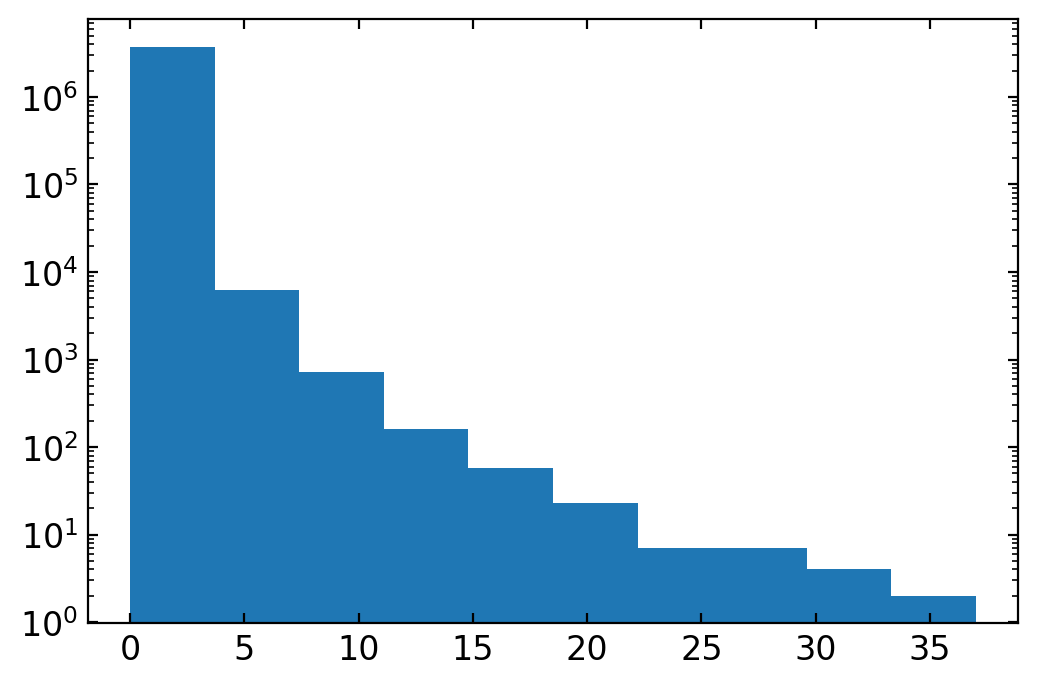

In [41]:
_, ax = plt.subplots()
ax.hist(richness)
ax.set(yscale="log")

# Plots

In [42]:
def _imshow(ax, binned_stats, **kwargs):
    return ax.imshow(
            binned_stats.statistic.T,
            origin="lower",
            extent=[binned_stats.x_edge[0], binned_stats.x_edge[-1], binned_stats.y_edge[0], binned_stats.y_edge[-1]],
            aspect="auto",
            **kwargs,
    )

Invalidating < 10


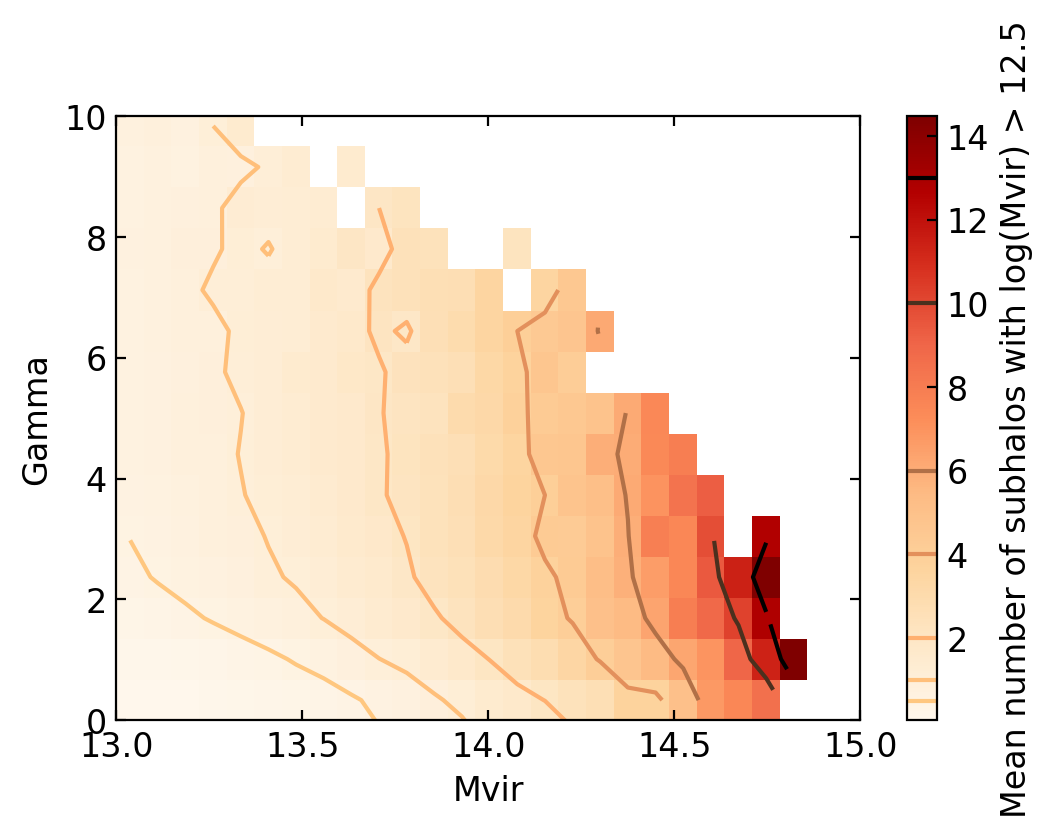

In [46]:
cut_p = parents[parents["halo_mvir"] > 1e13]
s = scipy.stats.binned_statistic_2d(
    np.log10(cut_p["halo_mvir"]), 
    cut_p["gamma2"],
    cut_p["richness"],
    statistic="mean",
    bins=(30, 30),
)
invalidate_unoccupied_bins(s, 10)

fig, ax = plt.subplots()
img = _imshow(ax, s, cmap="OrRd")

ax.set(
    xlabel="Mvir",
    ylabel="Gamma",
    xlim=(13, 15),
    ylim=(0, 10),
)
clb = fig.colorbar(img, ax=ax, label="Mean number of subhalos with log(Mvir) > 12.5")


contours = ax.contour(
        s.x_edge[:-1] + ((s.x_edge[1:] - s.x_edge[:-1]) / 2),    
        s.y_edge[:-1] + ((s.y_edge[1:] - s.y_edge[:-1]) / 2),    
        s.statistic.T,
        levels=[0, 0.5, 1, 2, 4, 6, 10, 13],           
        #levels=np.arange(20),
        cmap="copper_r",
        )

clb.add_lines(contours)
